In [69]:
from mesa import Agent, Model 
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['white', 'lightblue', 'blue', 'navy', 'midnightblue', 'black'])

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [70]:
class BoxAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.is_in_stack = False

In [71]:
class RobotAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.carrying_box = False
        self.carried_box = None

    def manhattan_distance(self, pos1, pos2):
        x1, y1 = pos1
        x2, y2 = pos2
        return abs(x1 - x2) + abs(y1 - y2)

    def move_towards(self, target_position):
        x, y = self.pos
        tx, ty = target_position
        dx, dy = tx - x, ty - y
    
        if dx != 0:
            next_x = x + np.sign(dx)
            if self.can_move_to(next_x, y):
                self.model.grid.move_agent(self, (next_x, y))
                return
    
        if dy != 0:
            next_y = y + np.sign(dy)
            if self.can_move_to(x, next_y):
                self.model.grid.move_agent(self, (x, next_y))
                return

    def can_move_to(self, x, y):
        return self.model.grid.is_cell_empty((x, y)) or self.model.stacks.get((x, y), 0) < 5

    def find_nearest_box(self):
        nearest_box = None
        min_distance = float('inf')
        for agent in self.model.schedule.agents:
            if isinstance(agent, BoxAgent) and not agent.is_in_stack:
                distance = self.manhattan_distance(self.pos, agent.pos)
                if distance < min_distance:
                    nearest_box = agent.pos
                    min_distance = distance
        return nearest_box

    def find_nearest_stack_or_box_to_deposit(self):
        nearest_stack = None
        nearest_single_box = None
        min_stack_distance = float('inf')
        min_box_distance = float('inf')

        for stack_pos, stack_height in self.model.stacks.items():
            if stack_height < 5:
                distance = self.manhattan_distance(self.pos, stack_pos)
                if distance < min_stack_distance:
                    nearest_stack = stack_pos
                    min_stack_distance = distance

        if nearest_stack is None:
            for agent in self.model.schedule.agents:
                if isinstance(agent, BoxAgent) and not agent.is_in_stack and agent != self.carried_box:
                    distance = self.manhattan_distance(self.pos, agent.pos)
                    if distance < min_box_distance:
                        nearest_single_box = agent.pos
                        min_box_distance = distance

        return nearest_stack if nearest_stack is not None else nearest_single_box

    def pickup_box(self):
        if not self.carrying_box:
            contents = self.model.grid.get_cell_list_contents(self.pos)
            for content in contents:
                if isinstance(content, BoxAgent) and not content.is_in_stack:
                    self.carrying_box = True
                    self.carried_box = content
                    print(f"Robot {self.unique_id} recogió caja {content.unique_id}")
                    break

    def deposit_box(self, target):
        if self.carrying_box:
            self.model.grid.move_agent(self.carried_box, target)
            self.carried_box.is_in_stack = True
            print(f"Robot {self.unique_id} depositó caja {self.carried_box.unique_id} en {target}")
            self.carrying_box = False
            self.carried_box = None

    def perform_action(self):
        if self.carrying_box:
            target = self.find_nearest_stack_or_box_to_deposit()
            if target:
                if self.pos == target or target in self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False):
                    self.deposit_box(target)
                else:
                    self.move_towards(target)
            else:
                print("mamaste padrino")
        else:
            # Si no lleva una caja, busca la caja más cercana
            target = self.find_nearest_box()
            print(f"Robot {self.unique_id} no lleva caja. Moviendo hacia {target}")
            if target:
                self.move_towards(target)
                if self.pos == target:
                    # Recoge la caja si llega a ella
                    self.pickup_box()

    def step(self):
        self.perform_action()


In [72]:
def get_grid(model):
    grid_state = np.zeros((model.grid.width, model.grid.height), dtype=int)

    for cell_contents, (x, y) in model.grid.coord_iter():
        # Asegurarse de que cell_contents sea una lista
        if not isinstance(cell_contents, list):
            cell_contents = [cell_contents]

        for content in cell_contents:
            if isinstance(content, RobotAgent):
                grid_state[x][y] = 1
            elif isinstance(content, BoxAgent):
                grid_state[x][y] = 2

    return grid_state

In [73]:
class WarehouseModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        self.stacks = {}  # Diccionario para llevar el seguimiento de los stacks
        self.num_agents = num_agents
        self.num_boxes = num_boxes
        self.steps = 0

        # Crear e inicializar agentes
        self.create_agents()

    def create_agents(self):
        # Asignación de identificadores únicos para cada agente
        agent_id = 0

        # Crear robots
        for _ in range(self.num_agents):
            robot = RobotAgent(agent_id, self)
            self.schedule.add(robot)
            self.grid.place_agent(robot, self.random_position_not_occupied())
            agent_id += 1

        # Crear cajas
        for _ in range(self.num_boxes):
            box = BoxAgent(agent_id, self)
            self.schedule.add(box)
            self.grid.place_agent(box, self.random_position_not_occupied())
            agent_id += 1

    def random_position_not_occupied(self):
        # Devuelve una posición aleatoria no ocupada en el grid
        while True:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            if self.grid.is_cell_empty((x, y)):
                return (x, y)

    def update_stacks(self):
        # Actualizar la información de los stacks en cada paso
        self.stacks = {}
        for contents in self.grid.coord_iter():
            stack_pos = contents[1]
            stack_count = sum(1 for agent in contents[0] if isinstance(agent, BoxAgent))
            if stack_count > 1:  # Considerar como stack si hay más de una caja
                self.stacks[stack_pos] = stack_count

    def step(self):
        self.update_stacks()
        self.schedule.step()
        # Recolectar datos aquí si es necesario
        self.datacollector.collect(self)
        self.steps += 1


In [74]:
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
NUM_BOXES = 25
MAX_STEPS = 5000

model = WarehouseModel(WIDTH, HEIGHT, NUM_AGENTS, NUM_BOXES)
model.running = True

print("Simulation start")
for i in range(MAX_STEPS):
    if not model.running:
        break
    model.step()
    # print(f"Step {i} completed")

print(f"Simulation ended after {model.schedule.steps} steps")


data = model.datacollector.get_model_vars_dataframe()

#print(f'Pasos totales para organizar todas las cajas: {model.schedule.steps}')


Simulation start
Robot 2 no lleva caja. Moviendo hacia (2, 13)
Robot 2 recogió caja 20
Robot 4 no lleva caja. Moviendo hacia (7, 3)
Robot 0 no lleva caja. Moviendo hacia (2, 13)
Robot 1 no lleva caja. Moviendo hacia (16, 2)
Robot 3 no lleva caja. Moviendo hacia (19, 5)
Robot 0 no lleva caja. Moviendo hacia (2, 13)
Robot 1 no lleva caja. Moviendo hacia (16, 2)
Robot 3 no lleva caja. Moviendo hacia (19, 5)
Robot 3 recogió caja 14
Robot 4 no lleva caja. Moviendo hacia (7, 3)
Robot 0 no lleva caja. Moviendo hacia (2, 13)
Robot 2 depositó caja 20 en (4, 13)
Robot 1 no lleva caja. Moviendo hacia (16, 2)
Robot 1 recogió caja 7
Robot 4 no lleva caja. Moviendo hacia (7, 3)
Robot 4 recogió caja 13
Robot 0 no lleva caja. Moviendo hacia (4, 13)
Robot 2 no lleva caja. Moviendo hacia (4, 13)
Robot 2 recogió caja 26
Robot 0 no lleva caja. Moviendo hacia (4, 13)
Robot 2 depositó caja 26 en (4, 13)
Robot 2 no lleva caja. Moviendo hacia (5, 9)
Robot 0 no lleva caja. Moviendo hacia (0, 15)
Robot 0 no lle

In [75]:
all_grid = model.datacollector.get_model_vars_dataframe()

5


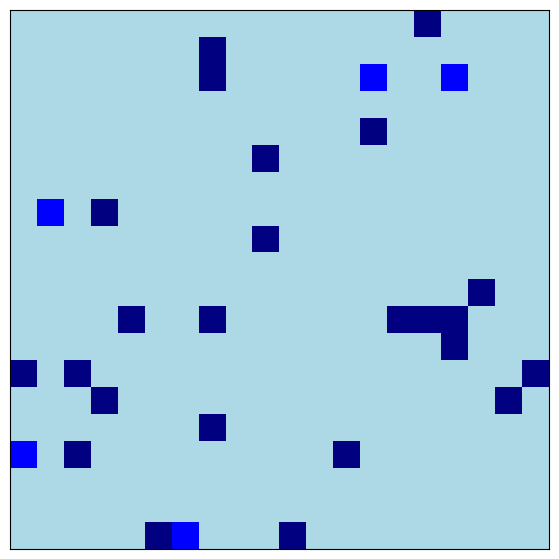

In [76]:
# def animate(frame):
#     grid = all_grid.iloc[frame][0]
#     patch.set_data(grid)
#     return [patch]  # Return as a list

# Create the initial plot
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
initial_grid = get_grid(model)  # Get the initial state of the grid
patch = plt.imshow(initial_grid, cmap=cmap, vmin=-1, vmax=5)

# Create the animation

def animate(frame):
    patch.set_data(data.iloc[frame][0])
steps = model.steps
print(len(model.stacks))

# anim = animation.FuncAnimation(fig, animate, frames=range(model.schedule.steps), interval=100)
anim = animation.FuncAnimation(fig , animate, frames=350, interval=100)

In [77]:
anim

In [78]:

#Reflexión:
#Esta actividad supuso un reto muy grande para mí. 
#A lo largo de este desafiante proyecto, me encontré con numerosos obstáculos que pusieron
#a prueba tanto mi conocimiento técnico como mi capacidad para resolver problemas de manera
#creativa y eficiente. A pesar de las dificultades, cada etapa del proceso se convirtió en 
#una valiosa oportunidad de aprendizaje.

#Al enfrentar los complejos problemas de programación y lógica involucrados en la simulación
#de agentes y su interacción dentro de un entorno dinámico, pude profundizar significativamente
#mi comprensión de conceptos clave en la programación orientada a objetos y la gestión de estados
#en sistemas multiagente. Aprendí la importancia de la paciencia y la meticulosidad al depurar el
#código, especialmente al trabajar con simulaciones interactivas donde cada componente depende 
#estrechamente del otro.

#lo que podría hacer este sistema más eficiente es trabajar con agentes por cuadrantes, para que cada uno
#de estos no pierda tiempo revisando las celdas que los otros harán
